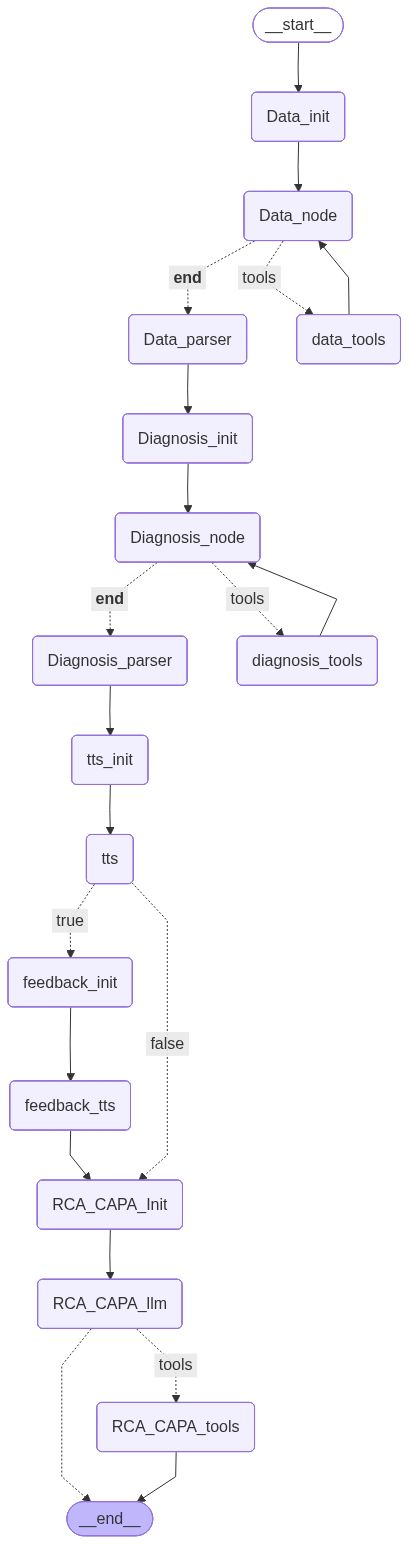

In [2]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition
from agent_node_tools import llm_agent_init,Data_Agent_init,Diagnosis_Agent_init,parser_node_init,comunication_init,tts_conv_init,condition_def,feedback_init,RCA_CAPA_init
from class_model import model_inference
from mock_database import fetch_data,log_currnet_data
from schema import data_output_schema,diagnosis_output_schema,automotive_state
from doc_gen import doc_specific_gen
import requests
from IPython.display import Image, display

data_tool_Node = ToolNode([fetch_data])
diagnosis_tool_Node = ToolNode([model_inference,log_currnet_data])
RCA_CAPA_tools = ToolNode([doc_specific_gen])

graph = StateGraph(automotive_state)

graph.add_node("Data_init",Data_Agent_init)
graph.add_node("Diagnosis_init",Diagnosis_Agent_init)

graph.add_node("Data_node",llm_agent_init([fetch_data]))
graph.add_node("Diagnosis_node",llm_agent_init([model_inference,log_currnet_data]))

graph.add_node("Data_parser",parser_node_init(data_output_schema,"Data_agent"))
graph.add_node("Diagnosis_parser",parser_node_init(diagnosis_output_schema,"Diagnosis_agent"))

graph.add_node("tts_init",tts_conv_init)
graph.add_node("tts",comunication_init("tts_prompt"))

graph.add_node("data_tools",data_tool_Node)
graph.add_node("diagnosis_tools",diagnosis_tool_Node)
graph.add_node("RCA_CAPA_tools",RCA_CAPA_tools)

graph.add_node("feedback_init",feedback_init)
graph.add_node("feedback_tts",comunication_init("feedback_prompt"))

graph.add_node("RCA_CAPA_Init",RCA_CAPA_init)

graph.add_node("RCA_CAPA_llm",llm_agent_init([doc_specific_gen]))

graph.add_edge(START,"Data_init")

graph.add_edge("Data_init","Data_node")
graph.add_conditional_edges("Data_node",tools_condition,{"tools": "data_tools", "__end__": "Data_parser"})
graph.add_edge("data_tools","Data_node")

graph.add_edge("Data_parser","Diagnosis_init")

graph.add_edge("Diagnosis_init","Diagnosis_node")
graph.add_conditional_edges("Diagnosis_node",tools_condition,{"tools": "diagnosis_tools", "__end__": "Diagnosis_parser"})
graph.add_edge("diagnosis_tools","Diagnosis_node")

graph.add_edge("Diagnosis_parser","tts_init")

graph.add_edge("tts_init","tts")
graph.add_conditional_edges("tts",condition_def,{"true":"feedback_init","false":"RCA_CAPA_Init"})

graph.add_edge("feedback_init","feedback_tts")

graph.add_edge("feedback_tts","RCA_CAPA_Init")

graph.add_edge("RCA_CAPA_Init","RCA_CAPA_llm")
graph.add_conditional_edges("RCA_CAPA_llm",tools_condition,{"tools": "RCA_CAPA_tools", "__end__": END})
graph.add_edge("RCA_CAPA_tools",END)

agent = graph.compile()

import requests
from IPython.display import Image, display

# 1. Get the graph logic as a Mermaid string
mermaid_code = agent.get_graph().draw_mermaid()

# 2. Encode it for the Mermaid Ink API
#    (We use basic encoding to handle special characters)
import base64
graphbytes = mermaid_code.encode("ascii")
base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("ascii")

# 3. Request the image
url = "https://mermaid.ink/img/" + base64_string
response = requests.get(url)

# 4. Display or Print Error
if response.status_code == 200:
    display(Image(response.content))
else:
    print("⚠️ Could not render image automatically.")
    print("Copy the text below and paste it into https://mermaid.live/ :")
    print("\n" + mermaid_code)